In [1]:
import os, sys

os.chdir("../../../../")
print(os.path.abspath("./"))

/data/projects/src/github.com/any35/MOS


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io


def run_ours_box_or_points(img_path:str, pts_sampled, pts_labels, model):
    # pts_sampled: (N, [x,y])
    # pts_labels: (N)
    image_np = np.array(Image.open(img_path))
    img_tensor = ToTensor()(image_np)
    # (bs, 1, N, [x,y])
    pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2])
    # (bs, 1, N)
    pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1])
    predicted_logits, predicted_iou = model(
        img_tensor[None, ...],
        pts_sampled,
        pts_labels,
    )

    # 根据iou排序，然后依次返回iou最大的几个
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(predicted_logits, sorted_ids[..., None, None], dim=2)

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="yellow", facecolor=(0, 0, 0, 0), lw=5))


def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:, :, 3] = 0
    color_mask = [0, 1, 0, 0.7]
    img[np.logical_not(mask)] = color_mask
    ax.imshow(img)

In [5]:
from run.baseline.models.efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
import zipfile

efficient_sam_vitt_model = build_efficient_sam_vitt()
efficient_sam_vitt_model.eval()

# Since EfficientSAM-S checkpoint file is >100MB, we store the zip file.
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()



EfficientSam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    

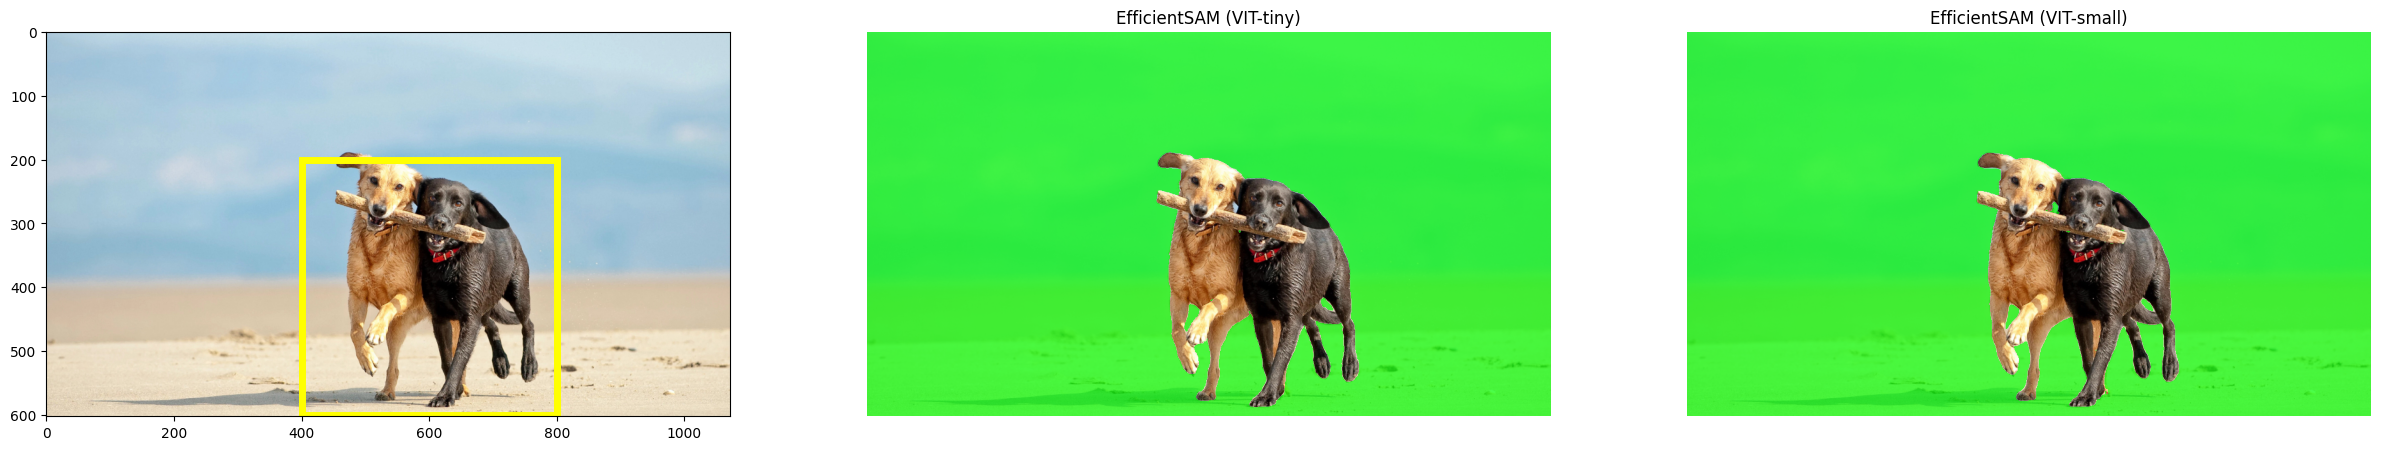

In [14]:
x1 = 400
y1 = 200
x2 = 800
y2 = 600
w = x2 - x1
h = y2 - y1

fig, ax = plt.subplots(1, 3, figsize=(30, 30))
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2, 3])
image_path = "run/baseline/models/efficient_sam/test-image/dogs.jpeg"
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([x1, y1, x2, y2], ax[0])
ax[0].imshow(image)


ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text("EfficientSAM (VIT-tiny)")
ax[1].axis("off")

ax[2].imshow(image)
mask_efficient_sam_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[2])
ax[2].title.set_text("EfficientSAM (VIT-small)")
ax[2].axis("off")


plt.show()

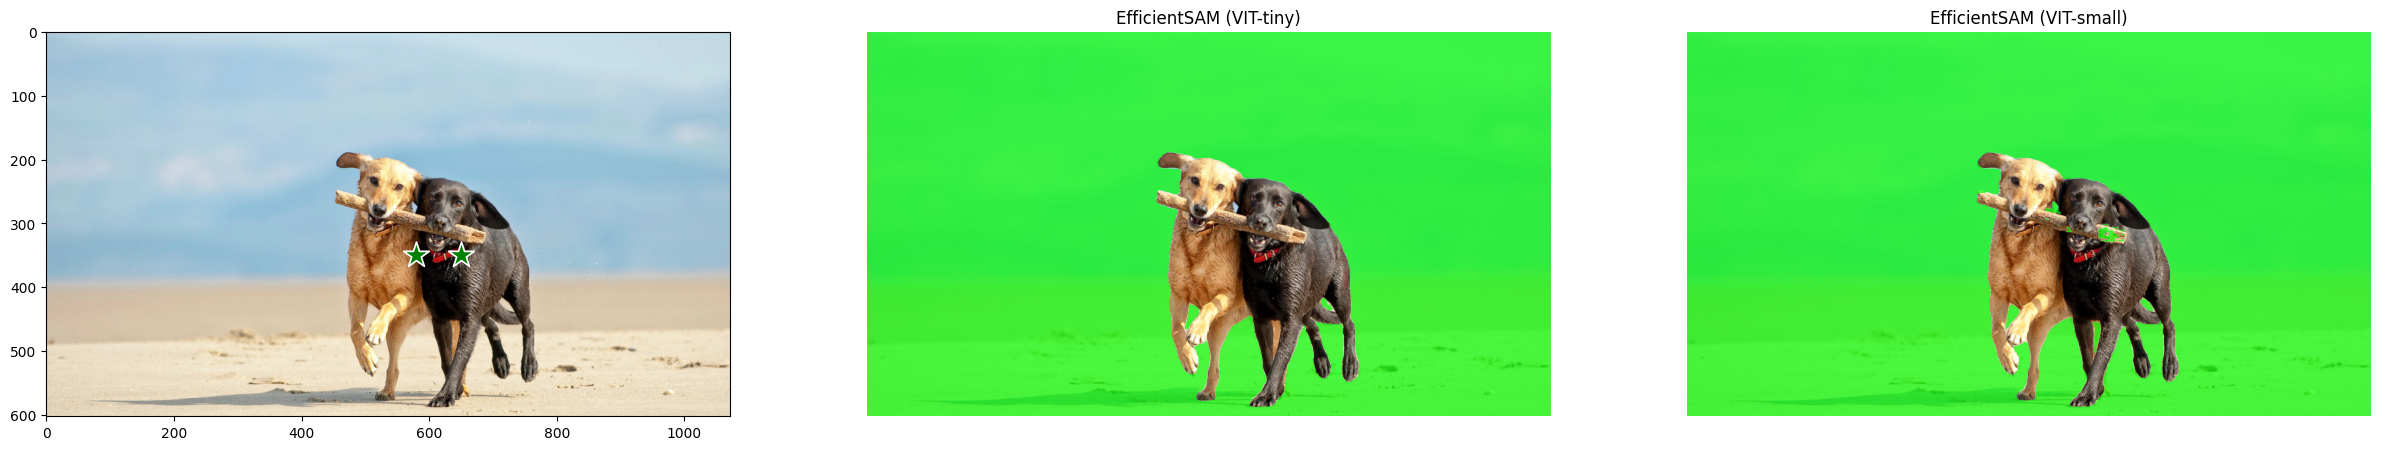

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(30, 30))

input_label = np.array([1, 1])
image_path = "run/baseline/models/efficient_sam/test-image/dogs.jpeg"
input_point = np.array([[580, 350], [650, 350]])
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
ax[0].imshow(image)


ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text("EfficientSAM (VIT-tiny)")
ax[1].axis("off")

ax[2].imshow(image)
mask_efficient_sam_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[2])
ax[2].title.set_text("EfficientSAM (VIT-small)")
ax[2].axis("off")


plt.show()